## Milesone 4: Hugging Face App and Video Demo
Using the reacticve app framework Shiny for Python and the Hugging Face Shiny spaces to create a web app that allows the user to upload an image of a tile and get the sidewalk segmentation. You can use this dashboard as a starting point.

Produce a 2min video showcasing the problem statement and your demo. The video can be uploaded to your Youtube channel or linked as an mp4 file in your Github repo.

In this initial step, essential libraries are imported to facilitate various aspects of the project. Matplotlib serves as a tool for data visualization, while Torch provides the foundational framework for deep learning tasks. PIL is utilized for image processing operations, while torchvision offers a range of transformation capabilities for image manipulation. Shiny, a web application framework for Python, enables the development of interactive user interfaces, and NumPy serves as a fundamental library for numerical computing tasks.

### Watch the demo here:

https://youtu.be/NH5yvuVBvfE

In [ ]:
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
from shiny import App, render, ui
from torchvision.transforms import functional as TF
import numpy as np

This stage involves the creation of a custom PyTorch module known as SAM, short for Spatial Attention Module. SAM is strategically designed to enhance the capabilities of the U-Net model by incorporating a spatial attention mechanism. By focusing on pertinent spatial regions during segmentation tasks, SAM aims to augment the model's accuracy and performance.


In [ ]:
class SAM(nn.Module):
    def __init__(self, in_channels):
        super(SAM, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        weights = self.sigmoid(self.conv(x))
        return x * weights

Building upon the foundational U-Net architecture, this step entails the integration of the previously defined SAM module into a modified version of the model. The U-Net model, renowned for its encoder-decoder architecture in segmentation tasks, undergoes enhancement with the inclusion of SAM. This modification aims to imbue the model with a heightened ability to discern and prioritize critical spatial features for improved segmentation outcomes.


In [ ]:
class UNetSAM(nn.Module):
    def __init__(self):
        super(UNetSAM, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            SAM(16),  
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            SAM(32),  
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Following the definition of the model architecture, the instantiated modified U-Net model is prepared for deployment by setting it to evaluation mode. This preparatory step ensures that the model is primed for inference tasks, ready to process input images and generate segmentation predictions with optimal efficiency and accuracy.

In [ ]:
model = UNetSAM()
model.eval()

With the groundwork laid for data preprocessing, a sequence of image transformations is established using torchvision's Compose function. These transformations encompass resizing input images to a standardized dimension and converting them into PyTorch tensors, thus facilitating seamless integration into the model's workflow.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

The predict_image function is introduced to encapsulate the process of generating segmentation predictions from input images. This function orchestrates a series of preprocessing steps, including image normalization and tensor conversion, before invoking the model to produce a segmentation mask. The resulting mask, represented as a NumPy array, encapsulates the model's predictions.

In [ ]:
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = TF.to_tensor(image)
    image = TF.normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    image = image.unsqueeze(0)
    
    with torch.no_grad():
        output = model(image)
    output_predictions = output[0][0].cpu().numpy()  
    
  
    output_predictions = (output_predictions - np.min(output_predictions)) / (np.max(output_predictions) - np.min(output_predictions))
    
    return output_predictions

This function imbues the probability map generated by the model with visual context by applying a color map. Leveraging the Viridis colormap, this enhancement facilitates intuitive interpretation of segmentation probabilities, contributing to a more insightful analysis of the model's predictions.


In [ ]:
def colorize_prob_map(prob_map):
    cmap = plt.get_cmap('viridis')
    colored_prob_map = cmap(prob_map)
    return colored_prob_map


A function is devised to seamlessly integrate the probability map with the original image, thereby creating an overlay that juxtaposes segmentation probabilities with the underlying image features. This fusion of visual elements enhances the interpretability and aesthetic appeal of the output.


In [ ]:
def blend_prob_map_with_image(prob_map, original_image):
    prob_map = colorize_prob_map(prob_map)
    blended_image = original_image.copy()
    blended_image[:, :, :3] = (blended_image[:, :, :3] * 0.6 + prob_map[:, :, :3] * 0.4).astype(np.uint8)  
    return blended_image

The user interface components for the Shiny web application are meticulously defined in this segment. These components, including file upload inputs and output plots, are instrumental in facilitating user interaction and showcasing the various stages of the segmentation process.

In this pivotal phase, the server logic for the Shiny web application is established. These server-side functions govern the rendering of the original image, probability map, and segmented image based on user inputs, thereby orchestrating the seamless flow of information within the application.

The final step entails the instantiation and execution of the Shiny web application. By amalgamating the defined UI components and server logic, an interactive platform is brought to fruition, empowering users to engage with the segmentation functionalities in a cohesive and intuitive manner.

In [ ]:
app_ui = ui.page_fluid(
    ui.input_file("image", "Upload your tile image"),
    ui.output_plot("original_image"),
    ui.output_plot("probability_map"),
    ui.output_plot("segmented_image")
)

def server(input, output, session):
    @output
    @render.plot(alt="Original Image")
    def original_image():
        file_info = input.image()
        if file_info:
            img_path = file_info[0]["datapath"]
            image = Image.open(img_path)
            plt.imshow(image)
            plt.axis('off')
            return plt.gcf()

    @output
    @render.plot(alt="Probability Map")
    def probability_map():
        file_info = input.image()
        if file_info:
            img_path = file_info[0]["datapath"]
            segmentation = predict_image(img_path)
            original_image = np.array(Image.open(img_path).convert("RGB"))
            blended_image = blend_prob_map_with_image(segmentation, original_image)
            plt.imshow(blended_image)
            plt.axis('off')
            return plt.gcf()

    @output
    @render.plot(alt="Segmented Image")
    def segmented_image():
        file_info = input.image()
        if file_info:
            img_path = file_info[0]["datapath"]
            segmentation = predict_image(img_path)
            threshold = np.max(segmentation) * 0.5  
            binary_mask = (segmentation > threshold).astype(int)
            plt.imshow(binary_mask, cmap='gray')
            plt.axis('off')
            return plt.gcf()

app = App(app_ui, server)

if __name__ == "__main__":
    app.run()


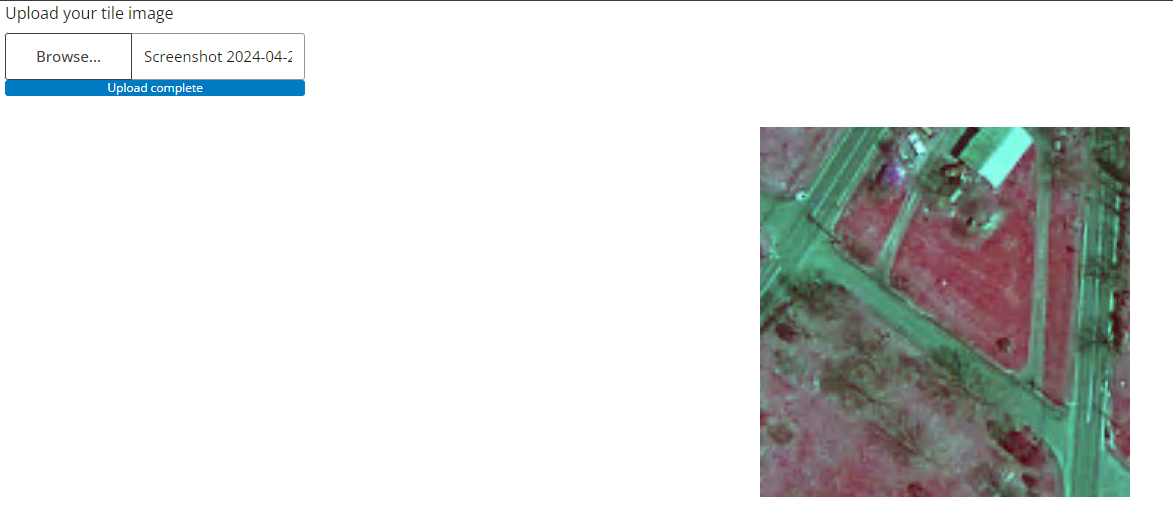
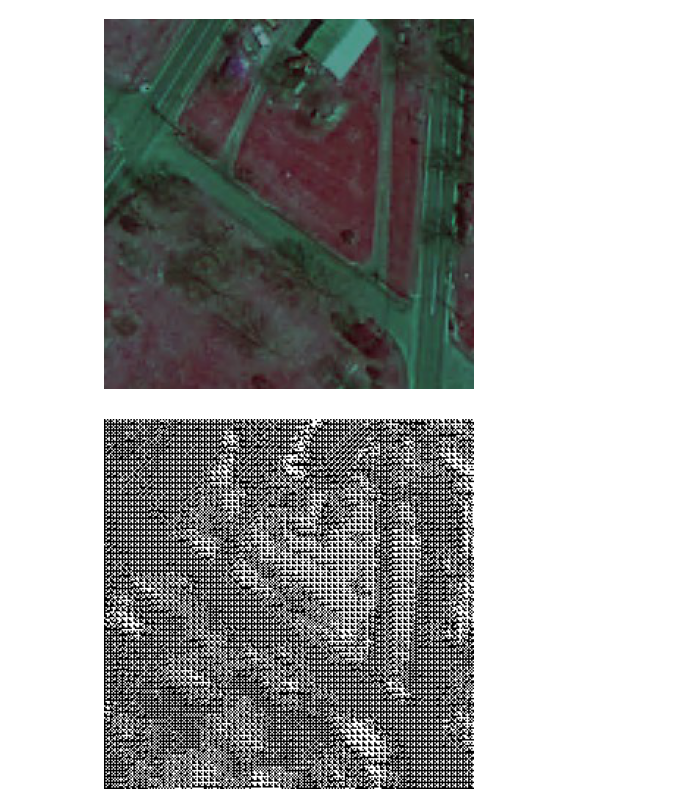